In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from datetime import date

C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [49]:
def portfolio_performance(weights, expected_returns, cov_matrix):
    """
    Returns the portfolio's expected return and standard deviation
    
    expected returns and cov_matrix variables are expected to be daily values
    """

    pf_return = np.sum(weights*expected_returns)*252
    pf_std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))*np.sqrt(252)
    return pf_return, pf_std

def negative_sharpe(weights, expected_returns, cov_matrix, risk_free):
    '''
    Calculates the negative Sharpe ratio
    args:
    weights -- portfolio weights
    expected_ returns -- mean returns
    cov_matrix -- covariance matrix
    risk_free -- risk free rate
    '''
    pf_return, pf_std = portfolio_performance(weights, expected_returns, cov_matrix)
    neg_sharpe = - (pf_return - risk_free)/pf_std
    return neg_sharpe

def portfolio_vol(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

def max_sharpe_ratio(expected_returns, cov_matrix, risk_free):
    """
    Calculates the maximimum sharpe ratio portfolio by formulating an optimization problem.
    """
    size_portfolio = expected_returns.count()
    bounds = tuple((0, 1) for x in range(size_portfolio))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix, risk_free) #args to be passed to optimising function
    results = sco.minimize(negative_sharpe, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

def min_vol(expected_returns, cov_matrix):
    """
    Calculates the minimum variance portfolio by formulating an optimization problem.
    """
    size_portfolio = expected_returns.count()
    bounds = tuple((0, 1) for x in range(size_portfolio))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix) #args to be passed to optimising function
    results = sco.minimize(portfolio_vol, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results
  

In [3]:
sp500 = pd.read_csv("sp500.csv")
tickers = sp500["Symbol"]
today = date.today()
tickers_data = data.DataReader(tickers,start="2019-1-1", end = today, data_source="yahoo")["Adj Close"]
tickers_data = tickers_data.dropna(axis='columns')
returns = tickers_data.pct_change()
expected_returns = returns.mean()
cov_matrix = returns.cov()
np.random.seed(20200725)

C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'CVS', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'RTX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'BDX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ISRG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'EQIX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pa

C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'SIVB', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'WRB', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'VIAC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'LKQ', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'TXT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\chiugabr\Anaconda3\lib\site-packages\pa

In [50]:
def portfolio_return(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[0]

def eff_return(expected_returns, cov_matrix, target_return):
    '''
    Calculate the optimal portfolio construction for target_return
    '''
    
    size_portfolio = expected_returns.count()
    constraints = ({'type':'eq','fun': lambda x:portfolio_return(x, expected_returns, cov_matrix)-target_return},
                   {'type':'eq', 'fun': lambda x:np.sum(x)-1})
    bounds = tuple((0, 1) for x in range(size_portfolio))
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix) #args to be passed to optimising function
    results = sco.minimize(portfolio_vol, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

def eff_frontier(expected_returns, cov_matrix, target_range):
    '''
    
    args:
    expected_returns -- 
    cov_matrix -- 
    target_range -- list of returns to plot
    
    '''
    graph = []
    for target in target_range:
        graph.append(eff_return(expected_returns, cov_matrix, target))
    return graph

In [55]:
def mvo(expected_returns, cov_matrix, risk_free):
    '''
    Construction of the efficient frontier by applying a linear combination of the Max Sharpe and Min Var portfolios
    This function does not allow short-selling in its estimation.
    
    '''
    
    max_sharpe = max_sharpe_ratio(expected_returns, cov_matrix, 0.01)
    ms_return, ms_std = portfolio_performance(max_sharpe['x'], expected_returns, cov_matrix)
    ms_weights = [round(i*100,2) for i in max_sharpe['x']] 
    ms_allocation = pd.DataFrame(ms_weights, index = expected_returns.index, columns = ['allocation'])
    ms_allocation = ms_allocation[ms_allocation != 0].dropna()
    
    minvar = min_var(expected_returns, cov_matrix)
    mv_return, mv_std = portfolio_performance(minvar['x'], expected_returns, cov_matrix)
    mv_weights = [round(i*100,2) for i in minvar['x']]
    mv_allocation = pd.DataFrame(mv_weights, index = expected_returns.index, columns = ['allocation'])
    mv_allocation = mv_allocation[mv_allocation != 0].dropna()
    
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print("Max Sharpe Portfolio Allocation")
        print("Expected return: ", ms_return)
        print("Standard deviation: ", ms_std)
        print(ms_allocation.T)
        print("Min Variance Portfolio Allocation")
        print("Expected return: ", mv_return)
        print("Standard deviation: ", mv_std)
        print(mv_allocation.T)
        
    graph = eff_frontier(expected_returns, cov_matrix, np.linspace(0.1,0.60,40))
    
    scttr_plt = np.zeros((2,40))
    i = 0
    for weights in graph:
        temp_return, temp_std = portfolio_performance(weights['x'], expected_returns, cov_matrix)
        scttr_plt[0,i] = temp_return
        scttr_plt[1,i] = temp_std
        i += 1

    
    plt.figure(figsize=(10,7))
    plt.scatter(scttr_plt[1,:], scttr_plt[0,:], marker='o')
    plt.scatter(ms_std, ms_return, marker="*", color="b", s=100, label="Max Sharpe")
    plt.scatter(mv_std, mv_return, marker="*", color="r", s=100, label = "Min Var")
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized return')   
        

Max Sharpe Portfolio Allocation
Expected return:  0.5136292649417391
Standard deviation:  0.20655376443464474
Symbols     AMZN  CHTR   AMD   TGT    GIS   ETN    CLX  EBAY    CMG  AKAM  \
allocation  0.82  5.92  6.14  1.23  22.25  0.93  12.18  7.91  18.03  8.06   

Symbols      CAG   TIF  MKTX  
allocation  3.06  7.63  5.82  
Min Variance Portfolio Allocation
Expected return:  0.25651676711112525
Standard deviation:  0.16783135102170293
Symbols     AMZN     VZ   WMT  GILD  CHTR   GIS    CLX  EBAY   HLT  CMG  \
allocation  3.22  11.78  3.95  4.09  0.07  4.37  20.75  2.29  8.47  2.2   

Symbols       TIF  INCY   SJM   EXR  CHRW   CPB  
allocation  13.23  0.35  8.29  5.93  5.43  5.57  


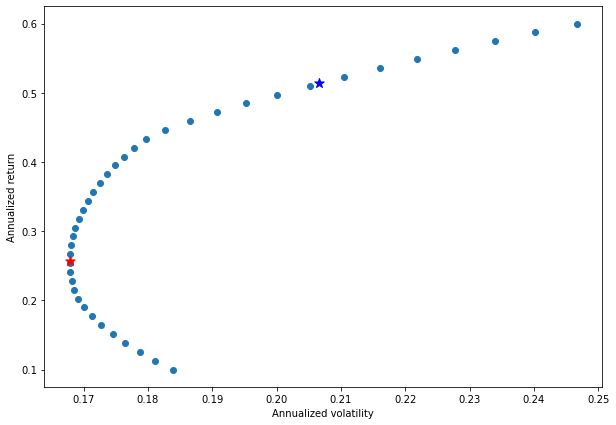

In [56]:
mvo(expected_returns, cov_matrix, 0.01)